# Statistical arbitrage with Cointegration

## Pairs Trading & Statistical Arbitrage

Statistical arbitrage refers to strategies that employ some statistical model or method to take
advantage of what appears to be relative mispricing of assets, while maintaining a level of
market neutrality.

Pairs trading is a conceptually straightforward strategy that has been employed by algorithmic traders since at least the mid-eighties ([Gatev, Goetzmann, and Rouwenhorst 2006](http://www-stat.wharton.upenn.edu/~steele/Courses/434/434Context/PairsTrading/PairsTradingGGR.pdf)). The goal is to find two assets whose prices have historically moved together, track the spread (the difference between their prices), and, once the spread widens, buy the
loser that has dropped below the common trend and short the winner. If the relationship persists, the long and/or the short leg will deliver profits as prices converge and the positions are closed.

This approach extends to a multivariate context by forming baskets from multiple securities and trading one asset against a basket of two baskets against each other.

## Pairs Trading in Practice

In practice, the strategy requires two steps:

1. **Formation phase**: Identify securities that have a long-term mean-reverting relationship. Ideally, the spread should have a high variance to allow for frequent profitable trades while reliably reverting to the common trend.
2. **Trading phase**: Trigger entry and exit trading rules as price movements cause thespread to diverge and converge.

Several approaches to the formation and trading phases have emerged from increasingly active research in this area, across multiple asset classes, over the last several years. The book outlines the key differences between them; the notebook dives into an example application.

## Imports & Settings

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
from collections import Counter

from time import time
from pathlib import Path

import numpy as np
import pandas as pd

from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [84]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

### Johansen Test Critical Values

In [85]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [86]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load Data

In [87]:
DATA_PATH = Path('..', 'data') 
STORE = DATA_PATH / 'assets.h5'

### Get backtest prices

Combine OHLCV prices for relevant stock and ETF tickers.

In [88]:
def get_backtest_prices():
    with pd.HDFStore('data.h5') as store:
        tickers = store['tickers']

    with pd.HDFStore(STORE) as store:
        prices = (pd.concat([
            store['stooq/us/nyse/stocks/prices'],
            store['stooq/us/nyse/etfs/prices'],
            store['stooq/us/nasdaq/etfs/prices'],
            store['stooq/us/nasdaq/stocks/prices']])
                  .sort_index()
                  .loc[idx[tickers.index, '2016':'2019'], :])
    print(prices.info(show_counts=True))
    prices.to_hdf('backtest.h5', 'prices')
    tickers.to_hdf('backtest.h5', 'tickers')

In [89]:
get_backtest_prices()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305824 entries, ('AA.US', Timestamp('2016-01-04 00:00:00')) to ('WYNN.US', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    305824 non-null  float64
 1   high    305824 non-null  float64
 2   low     305824 non-null  float64
 3   close   305824 non-null  float64
 4   volume  305824 non-null  float64
dtypes: float64(5)
memory usage: 13.2+ MB
None


### Load Stock Prices

In [90]:
# see notebook 05_cointagration_tests
stocks = pd.read_hdf('data.h5', 'stocks/close').loc['2015':]
stocks.info()
stocks

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 172 entries, AAPL.US to AEP.US
dtypes: float64(172)
memory usage: 1.7 MB


ticker,AAPL.US,AMZN.US,MSFT.US,BAC.US,GOOGL.US,NFLX.US,C.US,JPM.US,XOM.US,INTC.US,...,CLF.US,FITB.US,GEN.US,GAP.US,ADSK.US,FSLR.US,ADI.US,PCG.US,NVS.US,AEP.US
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.3203,15.4260,40.1536,15.3668,26.3819,49.849,45.0718,50.3059,63.7264,28.9303,...,6.6967,14.5194,10.27600,31.2373,59.53,44.545,46.7245,48.772,73.049,46.3700
2015-01-05,23.6361,15.1095,39.7826,14.9238,25.8791,47.311,43.6485,48.7429,61.9827,28.6040,...,6.2108,14.0833,10.13220,31.4391,58.66,41.830,45.8705,49.594,73.210,45.6898
2015-01-06,23.6381,14.7645,39.1972,14.4711,25.2406,46.501,42.1145,47.4804,61.6540,28.0687,...,6.0109,13.5169,9.97376,31.0230,57.50,40.860,44.7955,49.519,72.591,45.9386
2015-01-07,23.9734,14.9210,39.6975,14.5438,25.1663,46.743,42.5031,47.5512,62.2793,28.6587,...,6.5157,13.6660,10.06520,32.5231,57.38,41.750,45.2680,49.913,72.907,46.5922
2015-01-08,24.8927,15.0230,40.8676,14.8413,25.2540,47.779,43.1443,48.6122,63.3131,29.1950,...,6.9825,13.9755,10.24930,32.1495,58.80,43.630,46.0677,50.543,75.442,46.9913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,68.8225,89.4605,150.5140,32.8869,66.9786,333.200,70.4716,125.5370,58.7539,54.3557,...,8.2083,25.3039,13.91340,15.6452,183.91,57.980,113.2370,10.950,87.976,84.8095
2019-12-26,70.1874,93.4385,151.7760,33.1679,67.8774,332.630,71.5816,126.8730,58.8474,54.7318,...,8.1692,25.4341,13.78850,15.9020,184.24,58.660,113.2470,10.860,87.966,84.8459
2019-12-27,70.1597,93.4900,152.0480,33.0077,67.4874,329.090,71.4387,126.9610,58.6451,54.9702,...,8.0324,25.2543,13.87010,15.8131,185.38,56.410,112.9800,10.440,88.486,85.1279


### Load ETF Data

In [91]:
# see notebook 05_cointagration_tests
etfs = pd.read_hdf('data.h5', 'etfs/close').loc['2015':]
etfs.info()
etfs

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 1.3 MB


ticker,SPY.US,EEM.US,GLD.US,EFA.US,XLF.US,XLE.US,TLT.US,GDX.US,EWZ.US,HYG.US,...,EPU.US,WIP.US,PJP.US,INDY.US,XPH.US,STPZ.US,BRF.US,IDX.US,EWN.US,VNM.US
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,172.069,31.2787,114.08,49.2607,17.2861,58.0695,97.6041,17.6428,28.5620,65.7660,...,26.3338,48.3205,59.5551,27.644,47.7751,46.5885,16.212,21.057,20.6083,17.332
2015-01-05,168.957,30.7209,115.80,48.0975,16.9218,55.6700,99.0879,18.1069,27.5829,65.1567,...,25.9352,48.2820,59.1721,27.327,47.4247,46.5290,15.602,20.633,19.9071,17.004
2015-01-06,167.378,30.5919,117.12,47.5535,16.6656,54.8522,100.9170,19.0656,28.0758,64.9076,...,26.1610,48.1745,58.8240,26.463,46.9928,46.4249,15.451,20.633,19.6988,17.242
2015-01-07,169.435,31.2549,116.43,48.0818,16.8398,54.9686,100.6960,18.7126,28.8371,65.3095,...,26.0954,47.9929,60.1818,26.888,48.1821,46.4834,15.720,20.977,19.8706,17.195
2015-01-08,172.469,31.7878,115.94,48.7324,17.0901,56.2021,99.3622,18.4333,29.2975,65.8027,...,26.3936,48.0728,61.4590,27.718,49.2462,46.5637,15.943,21.074,20.1767,17.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,296.904,39.9678,141.27,65.1116,28.9749,52.2111,118.6900,27.5556,42.7073,83.1442,...,33.4480,52.1692,64.0911,36.100,45.3280,50.2998,25.342,22.084,32.4870,15.688
2019-12-26,298.482,40.2535,142.38,65.3943,29.1333,52.1945,118.9800,27.9588,43.6511,83.2684,...,33.8494,52.3300,63.6822,35.914,45.1433,50.3583,25.867,22.172,32.6914,15.708
2019-12-27,298.405,40.4156,142.33,65.5068,29.0591,51.9753,119.1090,27.7572,43.3034,83.2316,...,33.7954,52.5876,63.3112,35.942,44.6361,50.3583,26.039,22.129,32.7585,15.708


### Load Ticker Dictionary

In [92]:
names = pd.read_hdf('data.h5', 'tickers').to_dict()

In [93]:
pd.Series(names).count()

np.int64(304)

## Precompute Cointegration

In [94]:
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_tickers = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_tickers = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    n = len(etf_tickers) * len(stock_tickers)
    j = 0
    for i, s1 in enumerate(etf_tickers, 1):
        for s2 in stock_tickers:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j:5,.0f} ({j/n:3.1%}) | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                var = VAR(df)
                lags = var.select_order()
                result = [test_end, s1, s2]
                order = lags.selected_orders['aic']
                result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

### Define Test Periods

In [95]:
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

DatetimeIndex(['2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', name='date', freq='QE-DEC')

### Run Tests

In [96]:
# NON PARALLEL VERSION
# test_results = []
# columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
#            'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

# for test_end in dates:
#     print(test_end)
#     result = test_cointegration(etfs, stocks, test_end=test_end)
#     test_results.append(pd.DataFrame(result, columns=columns))

# pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

It is possible to parallelize the loop over `dates` using `joblib.Parallel` and `delayed`, as the computations for each `test_end` appear to be independent. This can provide a speedup if you have multiple CPU cores available, though the benefit may be limited if the number of `dates` is small (e.g., ~10-11 in your example) relative to the overhead of parallelization. The heavy lifting is inside `test_cointegration` (the nested loops over tickers), but since your question focuses on the outer loop, here's how to modify it.

### Key Notes:
- `n_jobs=-1` uses all available CPU cores. You can set it to a specific number (e.g., `n_jobs=4`) if you want to limit it.
- `verbose=10` will print progress information from joblib (e.g., which jobs are running). Adjust or remove if not needed. The `print(test_end)` in your original loop won't execute sequentially in parallel, but the verbose output can serve a similar purpose.
- The inner `print` statements in `test_cointegration` (e.g., every 1000 iterations) may appear interleaved or out of order in the console due to parallel execution, but this won't affect the results.
- Ensure your environment supports multiprocessing (e.g., no issues with shared resources like the `etfs` and `stocks` DataFrames, which are read-only here).
- If the speedup isn't sufficient, consider parallelizing the inner nested loops in `test_cointegration` instead (e.g., over pairs of tickers), as that's likely where most time is spent. That could be done similarly with `Parallel` but would require refactoring to generate the list of (s1, s2) pairs upfront.


11m45s

In [97]:
# # PARALLEL VERSION
# from joblib import Parallel, delayed

# test_results = []
# columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
#            'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

# # Parallelize the loop over dates
# results = Parallel(n_jobs=-1, verbose=10)(
#     delayed(test_cointegration)(etfs, stocks, test_end=test_end) for test_end in dates
# )

# # Convert each result to a DataFrame
# test_dfs = [pd.DataFrame(result, columns=columns) for result in results]

# # Concatenate and save
# pd.concat(test_dfs).to_hdf('backtest.h5', 'cointegration_test')

#### Reload  Test Results

In [ ]:
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()
test_results

<class 'pandas.core.frame.DataFrame'>
Index: 249744 entries, 0 to 22703
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  249744 non-null  datetime64[ns]
 1   s1        249744 non-null  object        
 2   s2        249744 non-null  object        
 3   eg1       249744 non-null  float64       
 4   eg2       249744 non-null  float64       
 5   trace0    249744 non-null  float64       
 6   trace1    249744 non-null  float64       
 7   eig0      249744 non-null  float64       
 8   eig1      249744 non-null  float64       
 9   w1        249744 non-null  float64       
 10  w2        249744 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 22.9+ MB


## Identify Cointegrated Pairs

### Significant Johansen Trace Statistic

In [99]:
# test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
#                            (test_results.trace1 < trace1_cv))

In [100]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [101]:
test_results.joh_sig.value_counts(normalize=True)

joh_sig
False    0.949132
True     0.050868
Name: proportion, dtype: float64

### Significant Engle Granger Test

In [102]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)

In [103]:
test_results.eg_sig.value_counts(normalize=True)

eg_sig
False    0.91255
True     0.08745
Name: proportion, dtype: float64

### Comparison Engle-Granger vs Johansen

In [104]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

coint
False    0.987595
True     0.012405
Name: proportion, dtype: float64

In [105]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249744 entries, 0 to 22703
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   test_end  249744 non-null  datetime64[ns]
 1   s1        249744 non-null  object        
 2   s2        249744 non-null  object        
 3   w1        249744 non-null  float64       
 4   w2        249744 non-null  float64       
 5   joh_sig   249744 non-null  bool          
 6   eg        249744 non-null  float64       
 7   s1_dep    249744 non-null  bool          
 8   eg_sig    249744 non-null  bool          
 9   coint     249744 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 14.3+ MB


In [106]:
test_results

,test_end,s1,s2,w1,w2,joh_sig,eg,s1_dep,eg_sig,coint
0,2016-12-31,SPY.US,AAPL.US,0.060598,0.336213,False,0.660334,False,False,False
1,2016-12-31,SPY.US,AMZN.US,0.142613,-0.151897,False,0.476889,True,False,False
2,2016-12-31,SPY.US,MSFT.US,0.163787,-0.136412,False,0.513778,True,False,False
3,2016-12-31,SPY.US,BAC.US,0.136688,-0.057910,False,0.477606,True,False,False
4,2016-12-31,SPY.US,GOOGL.US,0.082204,0.102017,False,0.700180,False,False,False
...,...,...,...,...,...,...,...,...,...,...
22699,2019-06-30,VNM.US,FSLR.US,1.226689,-0.176223,False,0.010013,True,True,False
22700,2019-06-30,VNM.US,ADI.US,0.624485,0.032279,False,0.762450,True,False,False
22701,2019-06-30,VNM.US,PCG.US,0.727903,-0.001373,False,0.691749,True,False,False
22702,2019-06-30,VNM.US,NVS.US,0.512736,0.167578,False,0.600209,True,False,False


### Comparison

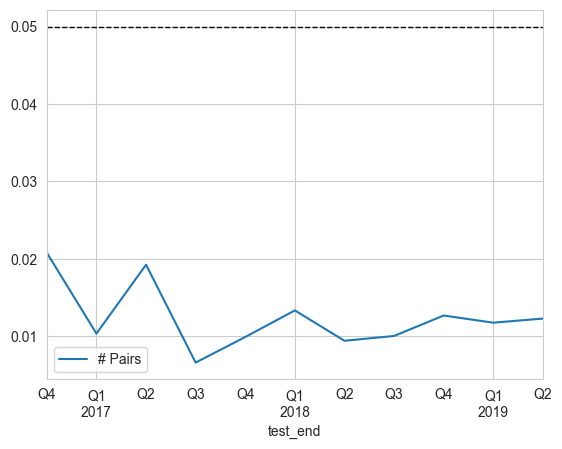

In [107]:
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

### Select Candidate Pairs

In [26]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [27]:
candidates = select_candidate_pairs(test_results)

In [28]:
candidates.to_hdf('backtest.h5', 'candidates')

In [63]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()
candidates

<class 'pandas.core.frame.DataFrame'>
Index: 29399 entries, 6 to 22699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  29399 non-null  datetime64[ns]
 1   w1        29399 non-null  float64       
 2   w2        29399 non-null  float64       
 3   joh_sig   29399 non-null  bool          
 4   eg        29399 non-null  float64       
 5   eg_sig    29399 non-null  bool          
 6   coint     29399 non-null  bool          
 7   y         29399 non-null  object        
 8   x         29399 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB


,test_end,w1,w2,joh_sig,eg,eg_sig,coint,y,x
6,2016-12-31,0.112295,0.052680,True,0.744821,False,False,SPY.US,C.US
12,2016-12-31,0.142082,-0.325900,False,0.044346,True,False,SPY.US,NVDA.US
15,2016-12-31,0.308580,-1.448434,True,0.015434,True,True,CSCO.US,SPY.US
21,2016-12-31,0.117961,0.007331,True,0.639055,False,False,SPY.US,GS.US
35,2016-12-31,0.221539,-0.529602,True,0.012558,True,True,SPY.US,AMD.US
...,...,...,...,...,...,...,...,...,...
22630,2019-06-30,0.724119,0.022012,True,0.242477,False,False,VNM.US,REGN.US
22664,2019-06-30,0.730042,0.106124,True,0.036398,True,True,EXPE.US,VNM.US
22681,2019-06-30,0.819393,-0.548634,True,0.032795,True,True,TFC.US,VNM.US
22695,2019-06-30,1.162844,-0.904759,True,0.027240,True,True,FITB.US,VNM.US


#### # Candidates over Time

<Axes: xlabel='test_end'>

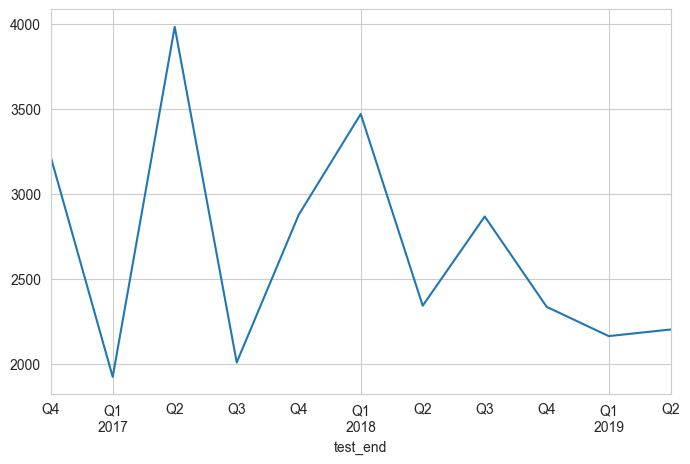

In [30]:
candidates.groupby('test_end').size().plot(figsize=(8, 5))

#### Most Common Pairs 

In [31]:
with pd.HDFStore('data.h5') as store:
    print(store.info())
    tickers = store['tickers']

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/etfs/close              frame        (shape->[2516,132])
/stocks/close            frame        (shape->[2516,172])
/tickers                 series       (shape->[1])       


In [32]:
with pd.HDFStore('backtest.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtest.h5
/candidates                    frame        (shape->[29399,9])  
/cointegration_test            frame        (shape->[249744,11])
/half_lives                    frame        (shape->[31446,4])  
/pair_data                     frame        (shape->[3951625,7])
/pair_trades                   frame        (shape->[126006,6]) 
/prices                        frame        (shape->[305824,5]) 
/tickers                       series       (shape->[1])        


In [33]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [34]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

,s1,s2
0,LMT.US,THD.US
1,TIP.US,WBA.US
2,CSX.US,HEDJ.US
3,AGQ.US,DAL.US
4,EPP.US,HPQ.US
5,EWD.US,SWKS.US
6,EPU.US,WBA.US
7,EWA.US,HPQ.US
8,BBY.US,TECL.US
9,EWJ.US,STT.US


In [35]:
with pd.HDFStore('backtest.h5') as store:
    prices = store['prices'].close.unstack('ticker').ffill(limit=5)
    tickers = store['tickers'].to_dict()

In [36]:
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(tickers)
cnt['name2'] = cnt.s2.map(tickers)
cnt.nlargest(10, columns='n')

,s1,s2,n,name1,name2
2393,LMT.US,THD.US,8,LOCKHEED MARTIN CORP,ISHARES MSCI THAILAND ETF
313,TIP.US,WBA.US,7,ISHARES TIPS BOND ETF,WALGREENS BOOTS ALLIANCE INC
455,CSX.US,HEDJ.US,6,CSX CORP,WISDOMTREE EUROPE HEDGED EQUITY
507,AGQ.US,DAL.US,6,PROSHARES ULTRA SILVER,DELTA AIR LINES INC
575,EPP.US,HPQ.US,6,ISHARES MSCI PACIFIC EX,HP INC
1009,EWD.US,SWKS.US,6,ISHARES MSCI SWEDEN ETF,SKYWORKS SOLUTIONS INC
1167,EPU.US,WBA.US,6,ISHARES MSCI PERU AND GLOBAL EXPOSURE,WALGREENS BOOTS ALLIANCE INC
1349,EWA.US,HPQ.US,6,ISHARES MSCI AUSTRALIA ETF,HP INC
3039,BBY.US,TECL.US,6,BEST BUY CO INC,DIREXION DAILY
126,EWJ.US,STT.US,5,ISHARES MSCI JAPAN ETF,STATE STREET CORP


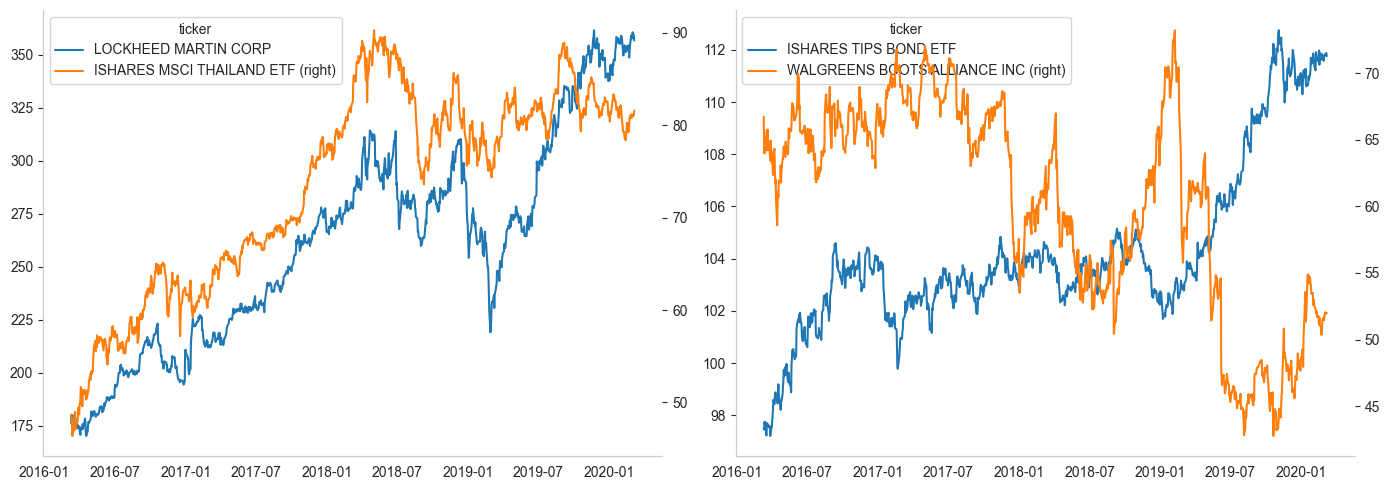

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in [0, 1]:
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=tickers).plot(secondary_y=tickers[s2],
                                                         ax=axes[i],
                                                         rot=0)
    axes[i].grid(False)
    axes[i].set_xlabel('')

sns.despine()
fig.tight_layout()

## Get Entry and Exit Dates 

### Smooth prices using Kalman filter

In [38]:
def KFSmoother(prices):
    """Estimate rolling mean"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [39]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('tmp.h5', 'smoothed')

In [40]:
smoothed_prices = pd.read_hdf('tmp.h5', 'smoothed')

### Compute rolling hedge ratio using Kalman Filter

In [41]:
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

### Estimate mean reversion half life

In [42]:
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T @ X) @ X.T @ y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [43]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [44]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29399 entries, 6 to 22699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   test_end  29399 non-null  datetime64[ns]
 1   w1        29399 non-null  float64       
 2   w2        29399 non-null  float64       
 3   joh_sig   29399 non-null  bool          
 4   eg        29399 non-null  float64       
 5   eg_sig    29399 non-null  bool          
 6   coint     29399 non-null  bool          
 7   y         29399 non-null  object        
 8   x         29399 non-null  object        
dtypes: bool(3), datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB


48m 20.0s

In [45]:
# pairs, half_lives = get_spread(candidates, smoothed_prices)

5m 4.0s

In [46]:
from joblib import Parallel, delayed

def get_spread_parallel(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        print(test_end.date(), len(period_candidates))

        def process_pair(i, y, x):
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])                

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pair_out = pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1)

            hl_out = [test_end, y, x, half_life]
            return pair_out, hl_out

        pair_results = Parallel(n_jobs=-1, verbose=10)(
            delayed(process_pair)(i, y, x)
            for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1)
        )

        pairs.extend([pr[0] for pr in pair_results])
        half_lives.extend([pr[1] for pr in pair_results])

    return pairs, half_lives

pairs, half_lives = get_spread_parallel(candidates, smoothed_prices)

2016-12-31 3219


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1994049275202473s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]:

2017-03-31 1924


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09949517250061035s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]

2017-06-30 3984


[Parallel(n_jobs=-1)]: Batch computation too fast (0.11612892150878906s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 434 task

2017-09-30 2009


[Parallel(n_jobs=-1)]: Batch computation too fast (0.12341713905334473s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 434 task

2017-12-31 2878


[Parallel(n_jobs=-1)]: Batch computation too fast (0.14033293724060059s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 434 task

2018-03-31 3471


[Parallel(n_jobs=-1)]: Batch computation too fast (0.13082599639892578s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 434 task

2018-06-30 2343


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1466350555419922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 434 tasks

2018-09-30 2868


[Parallel(n_jobs=-1)]: Batch computation too fast (0.13256192207336426s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 434 task

2018-12-31 2336


[Parallel(n_jobs=-1)]: Batch computation too fast (0.15865206718444824s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 434 task

2019-03-31 2164


[Parallel(n_jobs=-1)]: Batch computation too fast (0.17407989501953125s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 434 task

2019-06-30 2203


[Parallel(n_jobs=-1)]: Batch computation too fast (0.16710495948791504s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 434 task

### Collect Results

#### Half Lives

In [47]:
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29399 entries, 0 to 29398
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_end   29399 non-null  datetime64[ns]
 1   s1         29399 non-null  object        
 2   s2         29399 non-null  object        
 3   half_life  29399 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 918.8+ KB


In [48]:
hl.half_life.describe()

count    29399.000000
mean        24.968570
std         11.451782
min          5.000000
25%         20.000000
50%         24.000000
75%         28.000000
max        494.000000
Name: half_life, dtype: float64

In [49]:
hl.to_hdf('backtest.h5', 'half_lives')

#### Pair Data

In [50]:
pair_data = pd.concat(pairs)
pair_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3693792 entries, 2017-01-03 to 2019-12-31
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hedge_ratio  3693792 non-null  float64
 1   spread       3693792 non-null  float64
 2   z_score      3693792 non-null  float64
 3   s1           3693792 non-null  object 
 4   s2           3693792 non-null  object 
 5   period       3693792 non-null  int64  
 6   pair         3693792 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 225.5+ MB


In [51]:
pair_data.to_hdf('backtest.h5', 'pair_data')

In [52]:
pair_data = pd.read_hdf('backtest.h5', 'pair_data')
pair_data

ticker,hedge_ratio,spread,z_score,s1,s2,period,pair
date,,,,,,,
2017-01-03,-3.821428,3.229502,1.499594,SPY.US,C.US,1,1
2017-01-04,-3.817459,2.894236,1.243912,SPY.US,C.US,1,1
2017-01-05,-3.814355,3.281885,1.471685,SPY.US,C.US,1,1
2017-01-06,-3.812385,3.567788,1.605029,SPY.US,C.US,1,1
2017-01-09,-3.811602,3.843635,1.717055,SPY.US,C.US,1,1
...,...,...,...,...,...,...,...
2019-12-24,-0.278223,-0.047597,-1.428829,VNM.US,FSLR.US,11,2203
2019-12-26,-0.276491,-0.061751,-1.400366,VNM.US,FSLR.US,11,2203
2019-12-27,-0.275082,0.053004,-0.988627,VNM.US,FSLR.US,11,2203


### Identify Long & Short Entry and Exit Dates

In [53]:
# def get_trades(data):
#     pair_trades = []
#     for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
#         if i % 100 == 0:
#             print(i)

#         first3m = pair.first('3M').index
#         last3m = pair.last('3M').index

#         entry = pair.z_score.abs() > 2
#         entry = ((entry.shift() != entry)
#                  .mul(np.sign(pair.z_score))
#                  .fillna(0)
#                  .astype(int)
#                  .sub(2))

#         exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
#                 != np.sign(pair.z_score)).astype(int) - 1

#         trades = (entry[entry != -2].append(exit[exit == 0])
#                   .to_frame('side')
#                   .sort_values(['date', 'side'])
#                   .squeeze())
#         if not isinstance(trades, pd.Series):
#             continue
#         try:
#             trades.loc[trades < 0] += 2
#         except:
#             print(type(trades))
#             print(trades)
#             print(pair.z_score.describe())
#             break

#         trades = trades[trades.abs().shift() != trades.abs()]
#         window = trades.loc[first3m.min():first3m.max()]
#         extra = trades.loc[last3m.min():last3m.max()]
#         n = len(trades)

#         if window.iloc[0] == 0:
#             if n > 1:
#                 print('shift')
#                 window = window.iloc[1:]
#         if window.iloc[-1] != 0:
#             extra_exits = extra[extra == 0].head(1)
#             if extra_exits.empty:
#                 continue
#             else:
#                 window = window.append(extra_exits)

#         trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
#         trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
#         trades.hedge_ratio = trades.hedge_ratio.ffill()
#         pair_trades.append(trades)
#     return pair_trades

In [54]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (pd.concat([entry[entry != -2], exit[exit == 0]])
                  .to_frame('side')
                  .reset_index()  # Reset index to make 'date' a column for sorting
                  .sort_values(['date', 'side'])
                  .set_index('date')  # Set 'date' back as index
                  .squeeze())

        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = pd.concat([window, extra_exits])

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades


In [55]:
pair_trades = get_trades(pair_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [56]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119086 entries, 2017-01-03 to 2019-09-17
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           119086 non-null  object 
 1   s2           119086 non-null  object 
 2   hedge_ratio  119086 non-null  float64
 3   period       119086 non-null  int64  
 4   pair         119086 non-null  int64  
 5   side         119086 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.4+ MB


In [57]:
pair_trade_data.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2017-01-03,AA.US,DEM.US,-1.037475,1,2074,-1
2017-01-13,AA.US,DEM.US,-1.037475,1,2074,0
2017-01-03,AA.US,DIG.US,-0.600162,1,1829,-1
2017-01-10,AA.US,DIG.US,-0.600162,1,1829,0
2017-01-03,AA.US,DWX.US,-1.036419,1,2734,-1


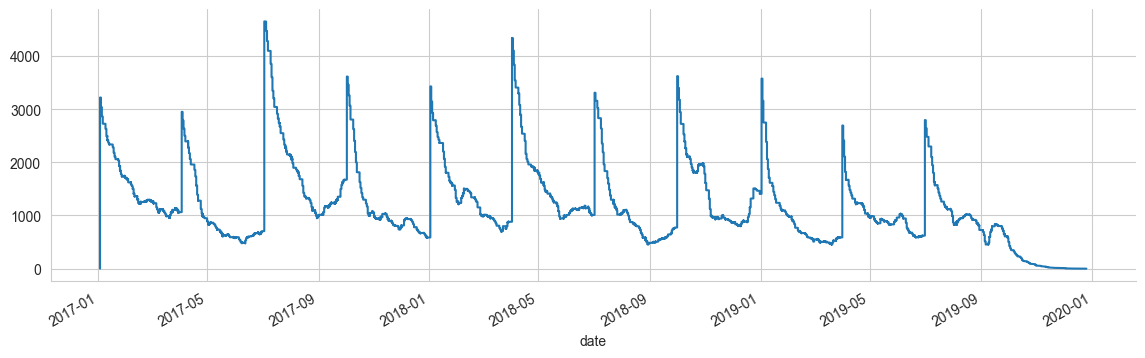

In [58]:
trades = pair_trade_data['side'].copy()
trades.loc[trades != 0] = 1
trades.loc[trades == 0] = -1
trades.sort_index().cumsum().plot(figsize=(14, 4))
sns.despine()

In [59]:
pair_trade_data.to_hdf('backtest.h5', 'pair_trades')